In [1]:
import os
import sys
import logging
import copy

sys.path.append("../")
adaptive_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if adaptive_root not in sys.path:
    sys.path.append(adaptive_root)
data_dir = os.path.join(adaptive_root, "notebooks", "fake_data")

import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import plotly.express as px

from simulation import fitters, simulators, utils, estimators

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [20]:
for param in utils.CHICK_SIMULATOR.params():
    print(f"{param} = {utils.CHICK_SIMULATOR.params()[param]:.4f}")

mu_b = 0.0041
mu_theta = 0.0977
sigma_b = 0.0016
sigma_theta = 0.0564
sigma1 = 0.2263
sigma0 = 0.2263


First, let's get a sense of how well the oracle model can estimate treatment effects. This will give us a baseline for comparing the errors of other models.

In [ ]:
def get_oracle_errors(simulator, J_total, repetitions):
    simulator = copy.deepcopy(simulator)
    oracle_fitter = fitters.FitterOracleHyperparameters()
    oracle_estimator = estimators.PosteriorMeanEstimator(oracle_fitter)

    p_star = utils.p_star(
        simulator.sigma0, simulator.sigma1, simulator.sigma_b, utils.CHICK_N
    )
    p_star = min(0.95, p_star)

    simulator.n = np.array([utils.CHICK_N] * J_total)
    simulator.p = np.array([p_star] * J_total)

    oracle_errors = []
    for rep in tqdm(range(repetitions), desc="rep for oracle"):
        data = simulator.simulate()
        oracle_estimates = oracle_estimator.result(data)
        oracle_errors.append(oracle_estimates.sample_mae())

    return oracle_errors

In [21]:
sim = copy.deepcopy(utils.CHICK_SIMULATOR)
oracle_errors = get_oracle_errors(sim, 130, 100)

rep for oracle:   0%|          | 0/100 [00:00<?, ?it/s]

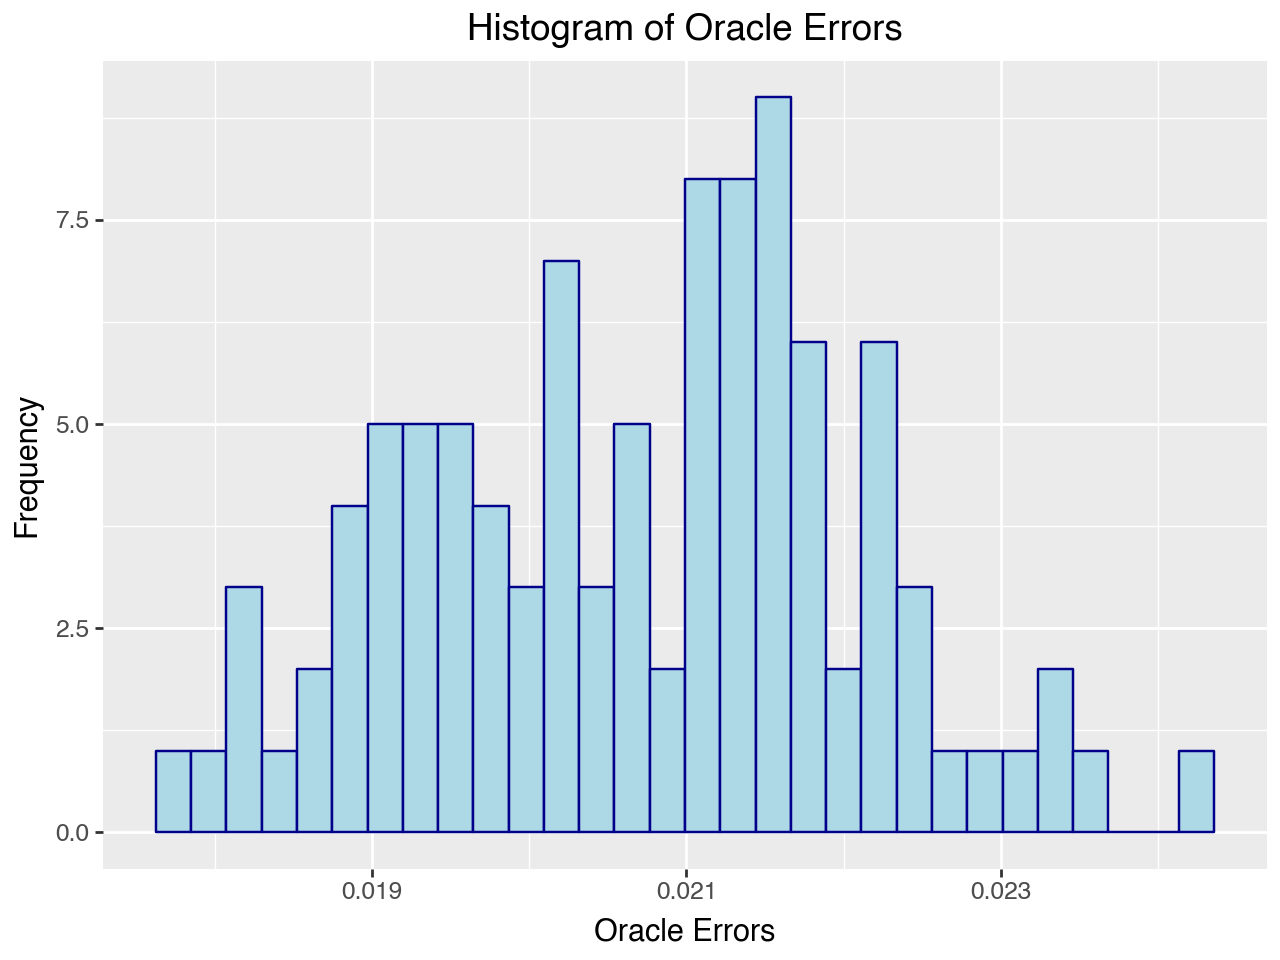

In [30]:
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal

# Convert oracle_errors to a DataFrame for plotting
oracle_errors_df = pd.DataFrame({'Oracle Errors': oracle_errors})

# Create the histogram
plot = (
    ggplot(oracle_errors_df, aes(x='Oracle Errors'))
    + geom_histogram(color="darkblue", fill="lightblue", bins=30)
    + labs(
        title="Histogram of Oracle Errors",
        x="Oracle Errors",
        y="Frequency"
    )
)

plot

Now let's repeat the above for various values of $p$ to make sure that the given $p^*$ actually minimizes the error.

p:   0%|          | 0/10 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

rep:   0%|          | 0/30 [00:00<?, ?it/s]

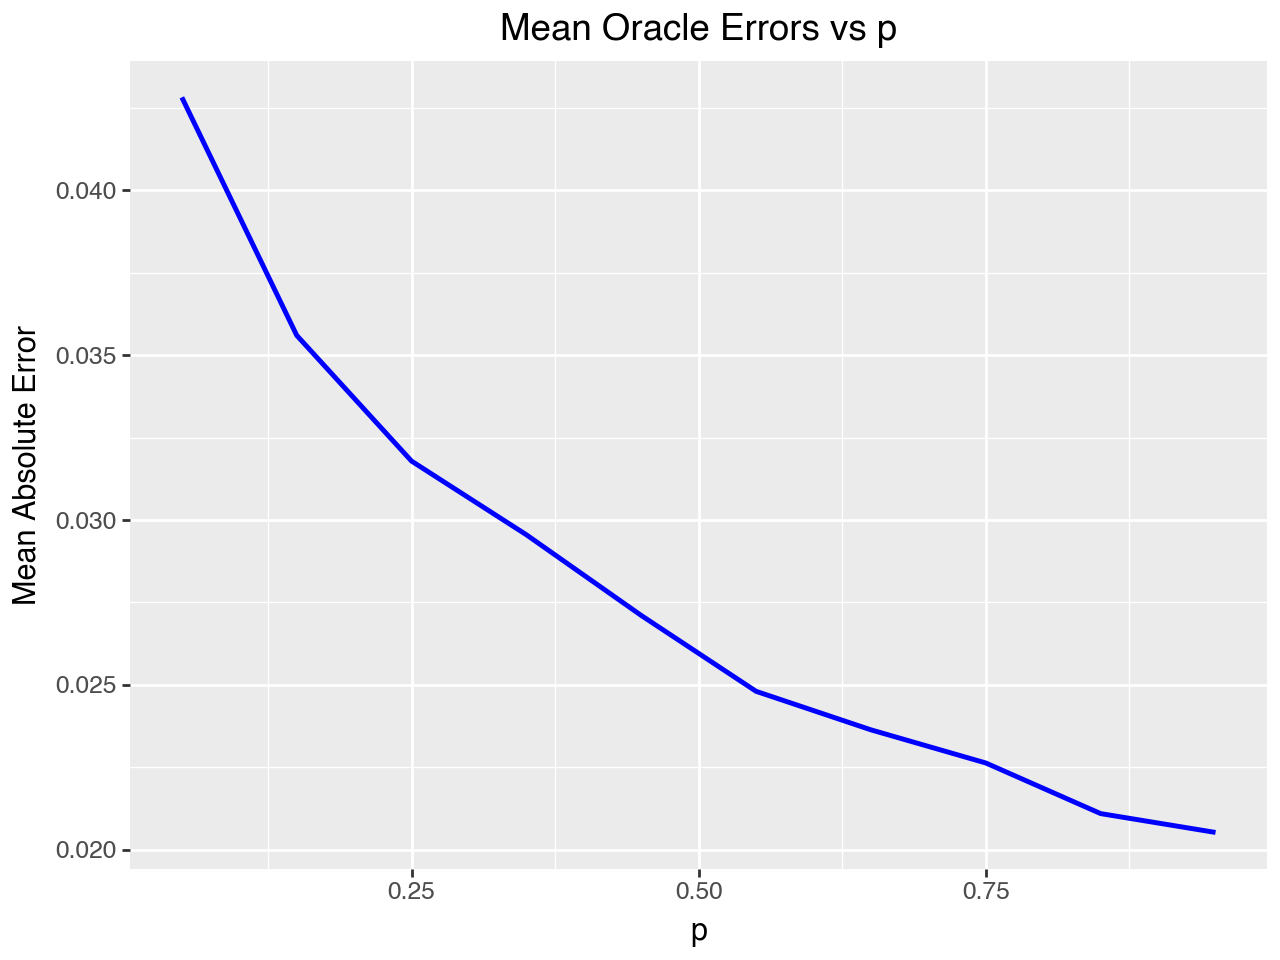

In [16]:
from plotnine import ggplot, aes, geom_line, labs

oracle_fitter = fitters.FitterOracleHyperparameters()
oracle_estimator = estimators.PosteriorMeanEstimator(oracle_fitter)
sim = copy.deepcopy(utils.CHICK_SIMULATOR)

mean_oracle_errors = {}

J_stage1 = 100
repetitions = 30

for p in tqdm(np.linspace(0.05, 0.95, 10), desc="p"):
    sim.n = np.array([utils.CHICK_N] * J_stage1)
    sim.p = np.array([p] * J_stage1)

    oracle_errors = []
    for rep in tqdm(range(repetitions), desc="rep", leave=False):
        data = sim.simulate()
        oracle_estimates = oracle_estimator.result(data)
        oracle_errors.append(oracle_estimates.sample_mae())

    mean_oracle_errors[p] = np.mean(np.array(oracle_errors))

# Convert mean_oracle_errors to a DataFrame for plotting
mean_oracle_errors_df = pd.DataFrame(
    list(mean_oracle_errors.items()), columns=["p", "Mean Error"]
)

# Create a line plot using plotnine
plot = (
    ggplot(mean_oracle_errors_df, aes(x="p", y="Mean Error"))
    + geom_line(color="blue", size=1)
    + labs(
        title="Mean Oracle Errors vs p",
        x="p",
        y="Mean Absolute Error"
    )
)

plot

In [ ]:
def compare_two_stage(simulator, J_stage0, J_stage1, repetitions, n, p0=0.5):
    sim = copy.deepcopy(simulator)
    flat_fitter = fitters.FitterFlatHyperpriors()
    post_mean_estimator = estimators.PosteriorMeanEstimator(flat_fitter)

    const_p0_errors = []

    for rep in tqdm(range(repetitions), desc="rep for constant ratio"):
        # generate data in first stage
        sim.n = np.array([n] * (J_stage0 + J_stage1))
        sim.p = np.array([p0] * (J_stage0 + J_stage1))

        data = sim.simulate()
        estimates = post_mean_estimator.result(data)
        const_p0_errors.append(estimates.sample_mae())

    two_stage_errors = []

    for rep in tqdm(range(repetitions), desc="rep for two-stage design"):
        # generate data in first stage
        sim.n = np.array([n] * J_stage0)
        sim.p = np.array([p0] * J_stage0)

        # estimate sigma_b from the data
        # and use this to estimate p_star_hat
        data_stage0 = sim.simulate()
        sampler = flat_fitter.fit(data_stage0)
        sigma_b_hat = np.mean(sampler.sigma_b)
        p_star_hat = utils.p_star(sim.sigma0, sim.sigma1, sigma_b_hat, n)
        p_star_hat = min(p_star_hat, 0.95)

        # generate data in the second stage and estimate treatment effects
        sim.n = np.array([n] * J_stage1)
        sim.p = np.array([p_star_hat] * J_stage1)

        data_stage1 = sim.simulate()
        data_both_stages = data_stage0.merge(data_stage1)
        estimates = post_mean_estimator.result(data_both_stages)
        two_stage_errors.append(estimates.sample_mae())

    return const_p0_errors, two_stage_errors

In [34]:
from plotnine import (
    ggplot,
    aes,
    geom_histogram,
    geom_vline,
    labs,
)


def plot_two_stage_comparison(const_p0_errors, two_stage_errors, baseline_error):
    # Calculate means for each error type
    mean_const_p0_errors = np.mean(const_p0_errors)
    mean_two_stage_errors = np.mean(two_stage_errors)

    # Combine the data into a single DataFrame for plotting
    errors_df = pd.DataFrame(
        {
            "Error": const_p0_errors + two_stage_errors,
            "Type": ["Const p=0.5 Errors"] * len(const_p0_errors)
            + ["Two Stage Errors"] * len(two_stage_errors),
        }
    )

    # Create the plot
    plot = (
        ggplot(errors_df, aes(x="Error", fill="Type", color="Type"))
        + geom_histogram(bins=30, alpha=0.5, position="identity")
        + geom_vline(
            xintercept=mean_const_p0_errors,
            color="#b41f53",
            linetype="dashed",
            size=1,
            alpha=0.5,
        )
        + geom_vline(
            xintercept=mean_two_stage_errors,
            color="#056e94",
            linetype="dashed",
            size=1,
            alpha=0.5,
        )
        + geom_vline(
            xintercept=baseline_error,
            color="#000000",
            linetype="dashed",
            size=1,
            alpha=0.5,
        )
        + labs(
            title="Histogram of Errors with Mean Lines",
            x="Mean Absolute Error",
        )
    )

    return plot

rep for oracle:   0%|          | 0/100 [00:00<?, ?it/s]

rep for constant ratio:   0%|          | 0/100 [00:00<?, ?it/s]

rep for two-stage design:   0%|          | 0/100 [00:00<?, ?it/s]

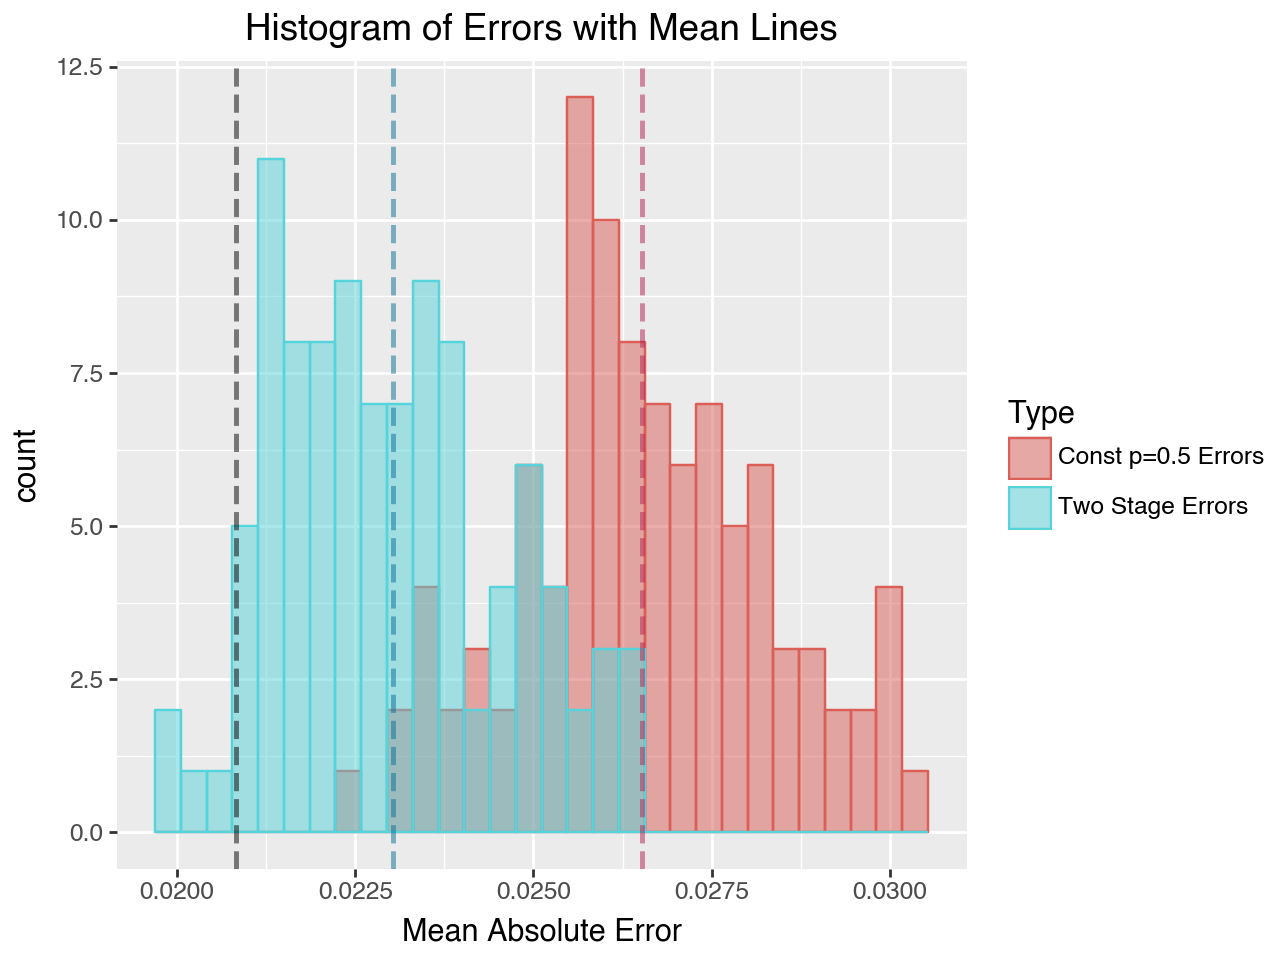

In [36]:
sim1 = copy.deepcopy(utils.CHICK_SIMULATOR)
baseline1 = np.mean(np.array(get_oracle_errors(sim1, J_total=130, repetitions=100)))
const1, two_stage1 = compare_two_stage(
    sim1, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)
plot_two_stage_comparison(const1, two_stage1, baseline1)

rep for oracle:   0%|          | 0/100 [00:00<?, ?it/s]

rep for constant ratio:   0%|          | 0/100 [00:00<?, ?it/s]

rep for two-stage design:   0%|          | 0/100 [00:00<?, ?it/s]

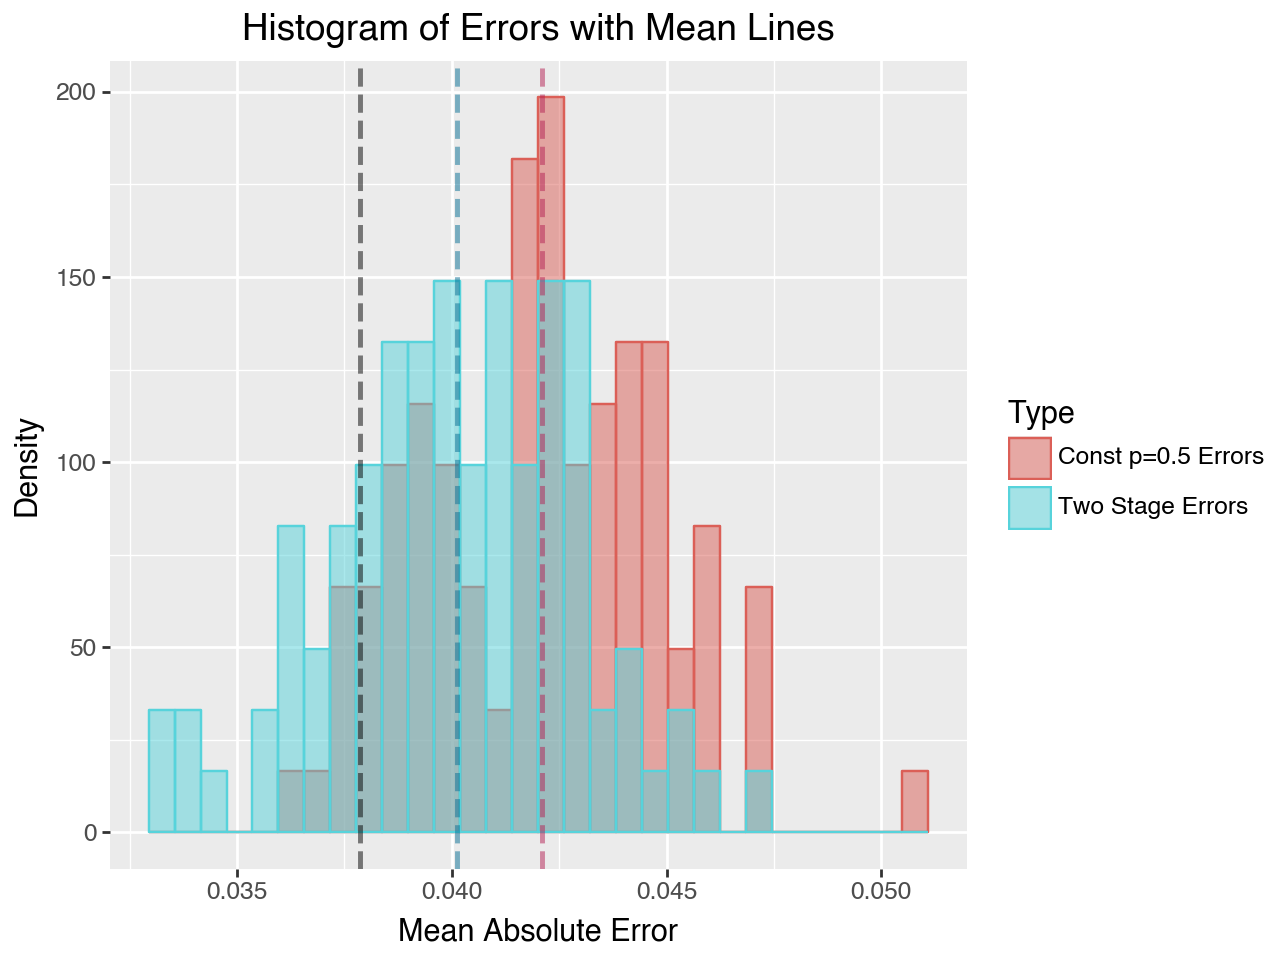

In [ ]:
sim2 = copy.deepcopy(utils.CHICK_SIMULATOR)
sim2.sigma1 = 3 * sim2.sigma0
baseline2 = np.mean(np.array(get_oracle_errors(sim2, J_total=130, repetitions=100)))
const2, two_stage2 = compare_two_stage(
    sim2, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)
plot_two_stage_comparison(const2, two_stage2, baseline2)

rep for oracle:   0%|          | 0/100 [00:00<?, ?it/s]

rep for constant ratio:   0%|          | 0/100 [00:00<?, ?it/s]

rep for two-stage design:   0%|          | 0/100 [00:00<?, ?it/s]

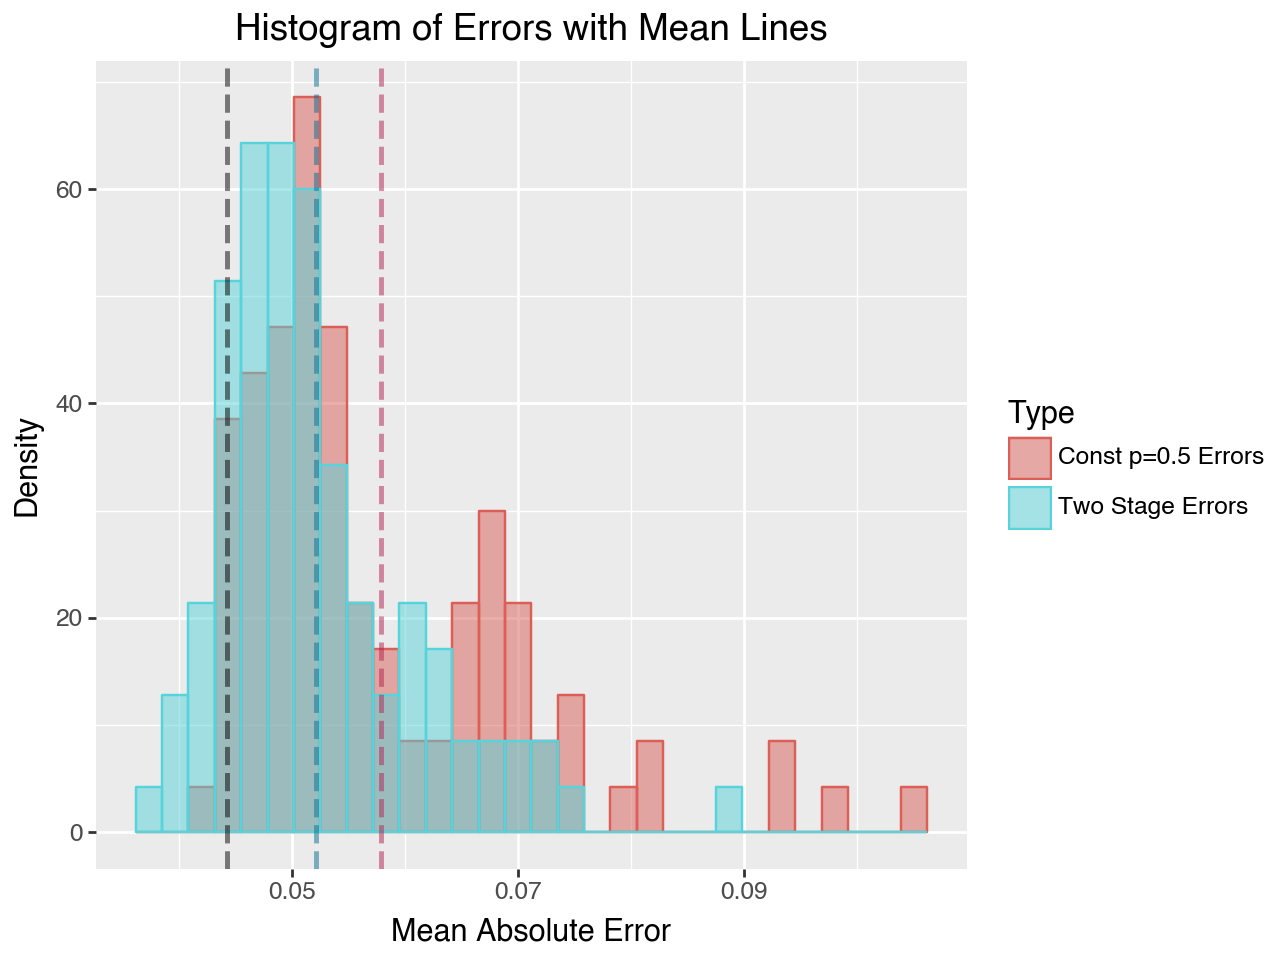

In [ ]:
sim4 = copy.deepcopy(utils.CHICK_SIMULATOR)
sim4.sigma1 = 10 * sim4.sigma0
baseline4 = np.mean(np.array(get_oracle_errors(sim4, J_total=130, repetitions=100)))
const4, two_stage4 = compare_two_stage(
    sim4, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)
plot_two_stage_comparison(const4, two_stage4, baseline4)

rep for oracle:   0%|          | 0/100 [00:00<?, ?it/s]

rep for constant ratio:   0%|          | 0/100 [00:00<?, ?it/s]

rep for two-stage design:   0%|          | 0/100 [00:00<?, ?it/s]

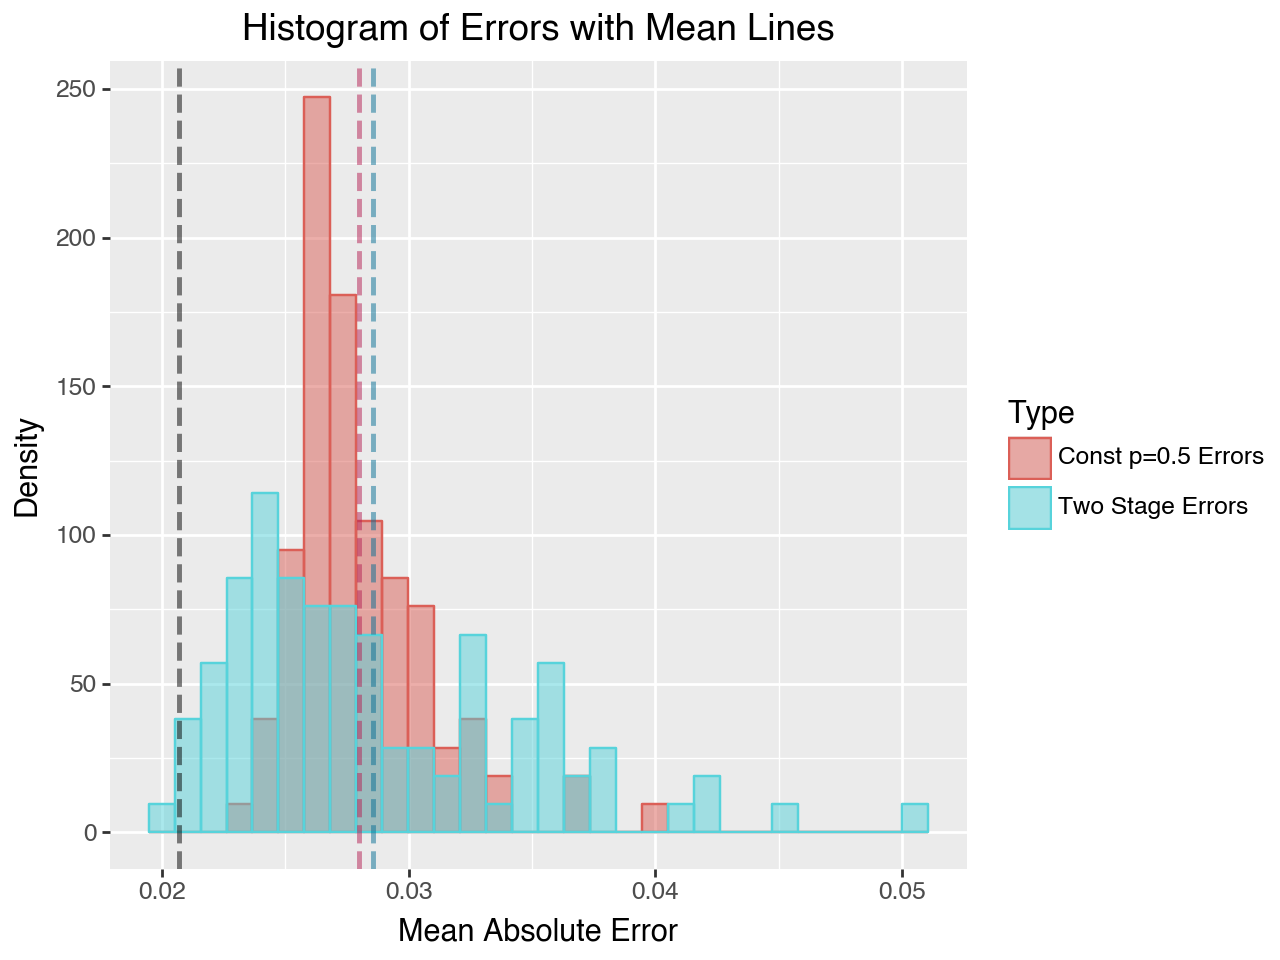

In [ ]:
sim3 = copy.deepcopy(utils.CHICK_SIMULATOR)
sim3.sigma0 = 3 * sim3.sigma1
baseline3 = np.mean(np.array(get_oracle_errors(sim3, J_total=130, repetitions=100)))
const3, two_stage3 = compare_two_stage(
    sim3, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)
plot_two_stage_comparison(const3, two_stage3, baseline3)

rep for oracle:   0%|          | 0/100 [00:00<?, ?it/s]

rep for constant ratio:   0%|          | 0/100 [00:00<?, ?it/s]

rep for two-stage design:   0%|          | 0/100 [00:00<?, ?it/s]

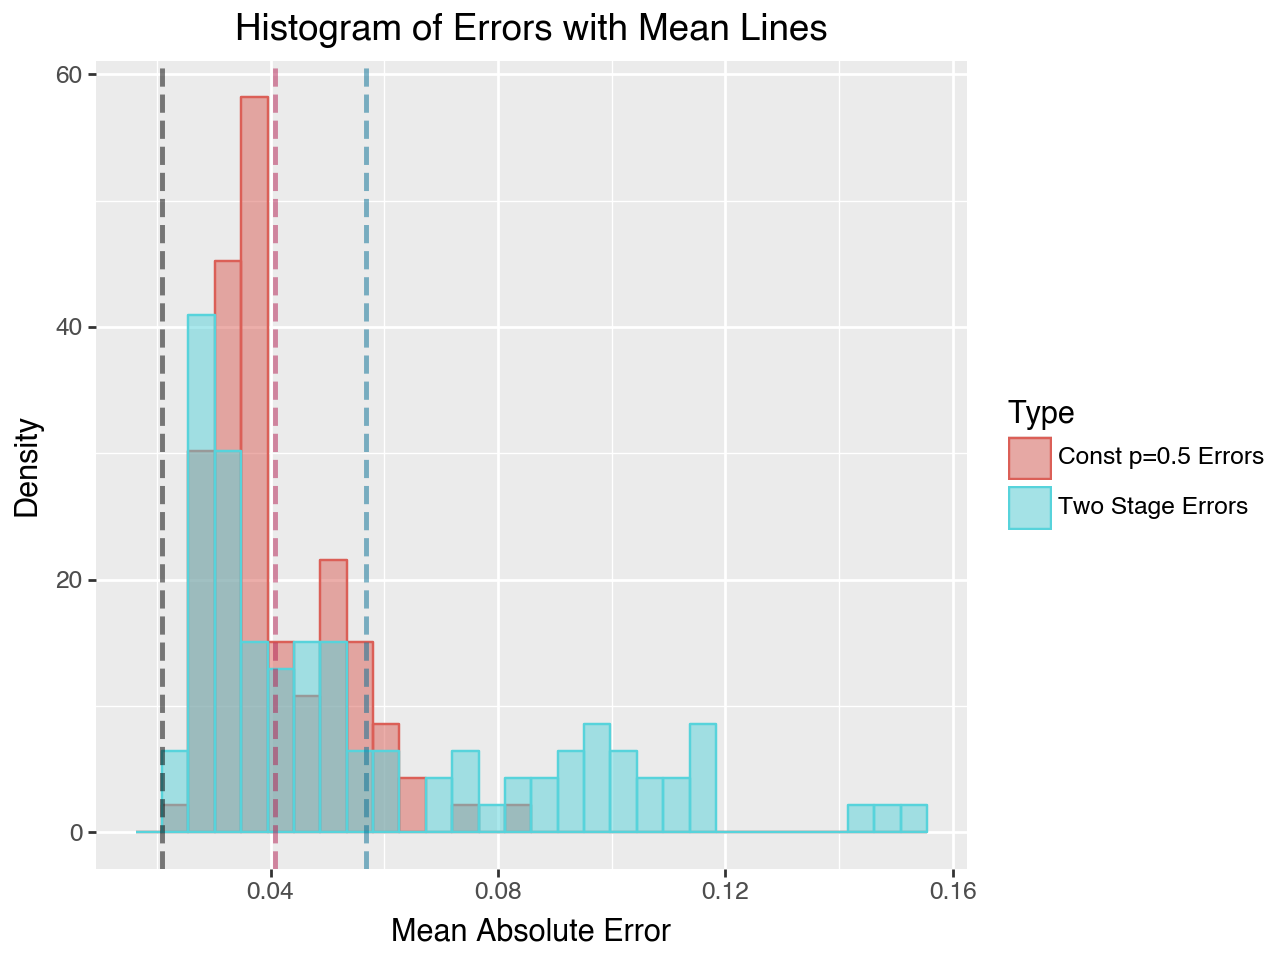

In [ ]:
sim5 = copy.deepcopy(utils.CHICK_SIMULATOR)
sim5.sigma0 = 10 * sim5.sigma1
baseline5 = np.mean(np.array(get_oracle_errors(sim5, J_total=130, repetitions=100)))
const5, two_stage5 = compare_two_stage(
    sim5, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)
plot_two_stage_comparison(const5, two_stage5, baseline5)

In [ ]:
sim2 = copy.deepcopy(utils.CHICK_SIMULATOR)
sim2.sigma1 = 3 * sim2.sigma0
sim2_oracle_errors = get_oracle_errors(sim2)
const2, two_stage2 = compare_two_stage(
    sim, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)
plot_two_stage_comparison(const2, two_stage2, np.mean(np.array(sim2_oracle_errors)))

rep for oracle:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
const_p0_errors, two_stage_errors = compare_two_stage(
    sim, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)

rep:   0%|          | 0/100 [00:00<?, ?it/s]

rep:   0%|          | 0/100 [00:00<?, ?it/s]

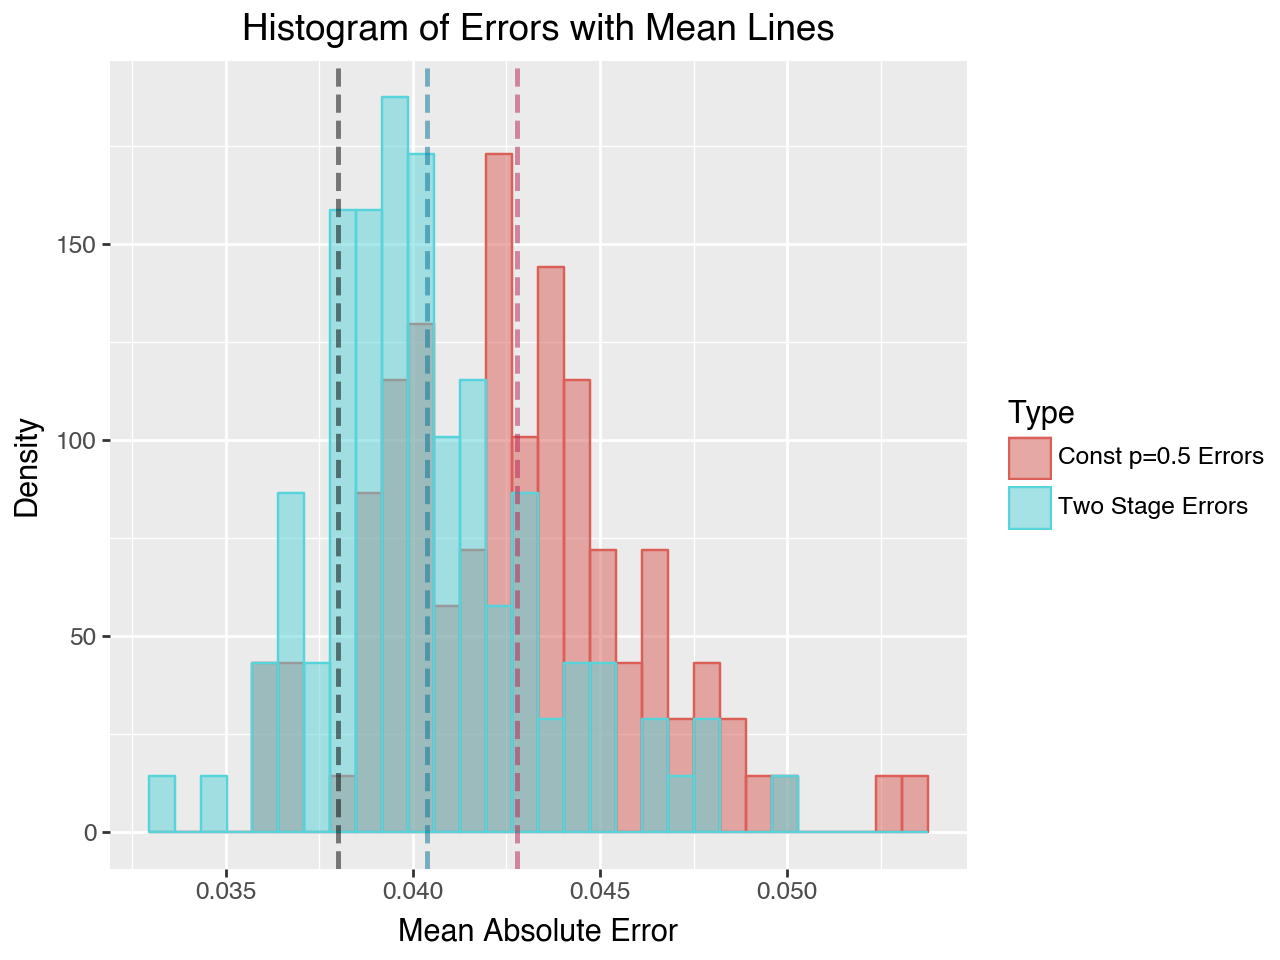

In [18]:
from plotnine import (
    ggplot,
    aes,
    geom_histogram,
    geom_density,
    geom_vline,
    labs,
    theme_minimal,
    xlim,
)

# Calculate means for each error type
mean_const_p0_errors = np.mean(const_p0_errors)
mean_two_stage_errors = np.mean(two_stage_errors)
baseline_error = 0.038

# Combine the data into a single DataFrame for plotting
errors_df = pd.DataFrame(
    {
        "Error": const_p0_errors + two_stage_errors,
        "Type": ["Const p=0.5 Errors"] * len(const_p0_errors)
        + ["Two Stage Errors"] * len(two_stage_errors),
    }
)

# Create the plot
plot = (
    ggplot(errors_df, aes(x="Error", fill="Type", color="Type"))
    + geom_histogram(aes(y="..density.."), bins=30, alpha=0.5, position="identity")
    + geom_vline(
        xintercept=mean_const_p0_errors,
        color="#b41f53",
        linetype="dashed",
        size=1,
        alpha=0.5,
    )
    + geom_vline(
        xintercept=mean_two_stage_errors,
        color="#056e94",
        linetype="dashed",
        size=1,
        alpha=0.5,
    )
    + geom_vline(
        xintercept=baseline_error, color="#000000", linetype="dashed", size=1, alpha=0.5
    )
    + labs(
        title="Histogram of Errors with Mean Lines",
        x="Mean Absolute Error",
        y="Density",
    )
)

plot

In [21]:
oracle_fitter = fitters.FitterOracleHyperparameters()
oracle_estimator = estimators.PosteriorMeanEstimator(oracle_fitter)
sim = copy.deepcopy(utils.CHICK_SIMULATOR)
sim.sigma0 = 3 * sim.sigma1

p_star = utils.p_star(sim.sigma0, sim.sigma1, sim.sigma_b, utils.CHICK_N)
p_star = min(0.95, p_star)

J_stage0 = 30
J_stage1 = 100
repetitions = 100

sim.n = np.array([utils.CHICK_N] * (J_stage0 + J_stage1))
sim.p = np.array([p_star] * (J_stage0 + J_stage1))

oracle_errors = []
for rep in tqdm(range(repetitions), desc="rep"):
    data = sim.simulate()
    oracle_estimates = oracle_estimator.result(data)
    oracle_errors.append(oracle_estimates.sample_mae())

mean_oracle_error = np.mean(np.array(oracle_errors))
print(f"Mean oracle error: {mean_oracle_error:.3f}")

rep:   0%|          | 0/100 [00:00<?, ?it/s]

Mean oracle error: 0.038


In [29]:
sim = copy.deepcopy(utils.CHICK_SIMULATOR)
print(utils.CHICK_SIMULATOR.params)
sim.sigma0 = 3 * sim.sigma1

const_bigger_sigma0, two_stage_bigger_sigma0 = compare_two_stage(
    sim, J_stage0=30, J_stage1=100, repetitions=100, n=utils.CHICK_N
)

<bound method ExperimentSimulator.params of <simulation.simulators.StaticExperimentSimulator object at 0x15a138830>>


rep:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

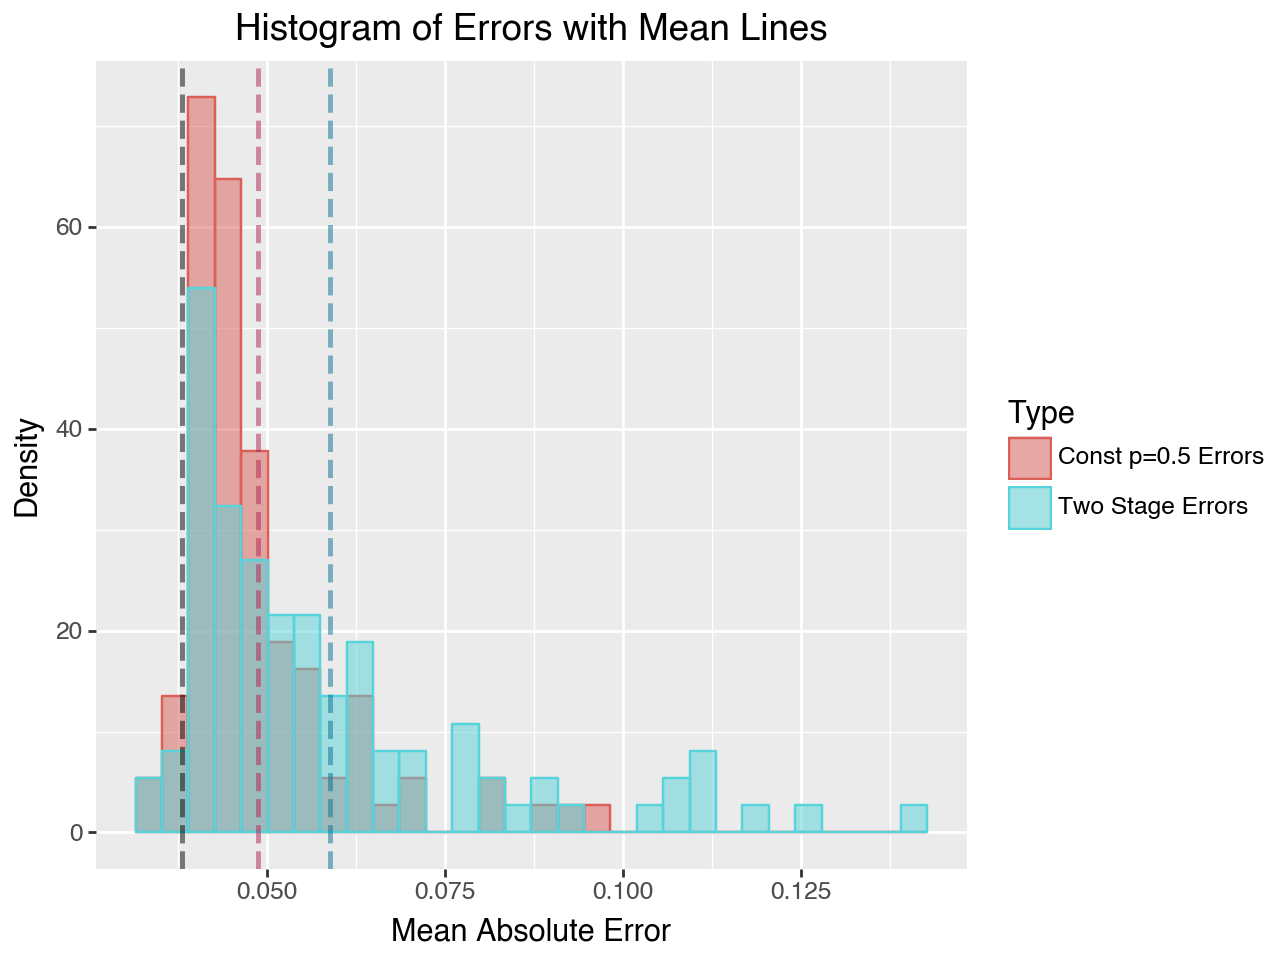

In [ ]:
plot_two_stage_comparison(const_bigger_sigma0, two_stage_bigger_sigma0, 0.038)

In [32]:
a, b = compare_two_stage(utils.CHICK_SIMULATOR, 30, 100, 100, utils.CHICK_N)

rep:   0%|          | 0/100 [00:00<?, ?it/s]

rep:   0%|          | 0/100 [00:00<?, ?it/s]

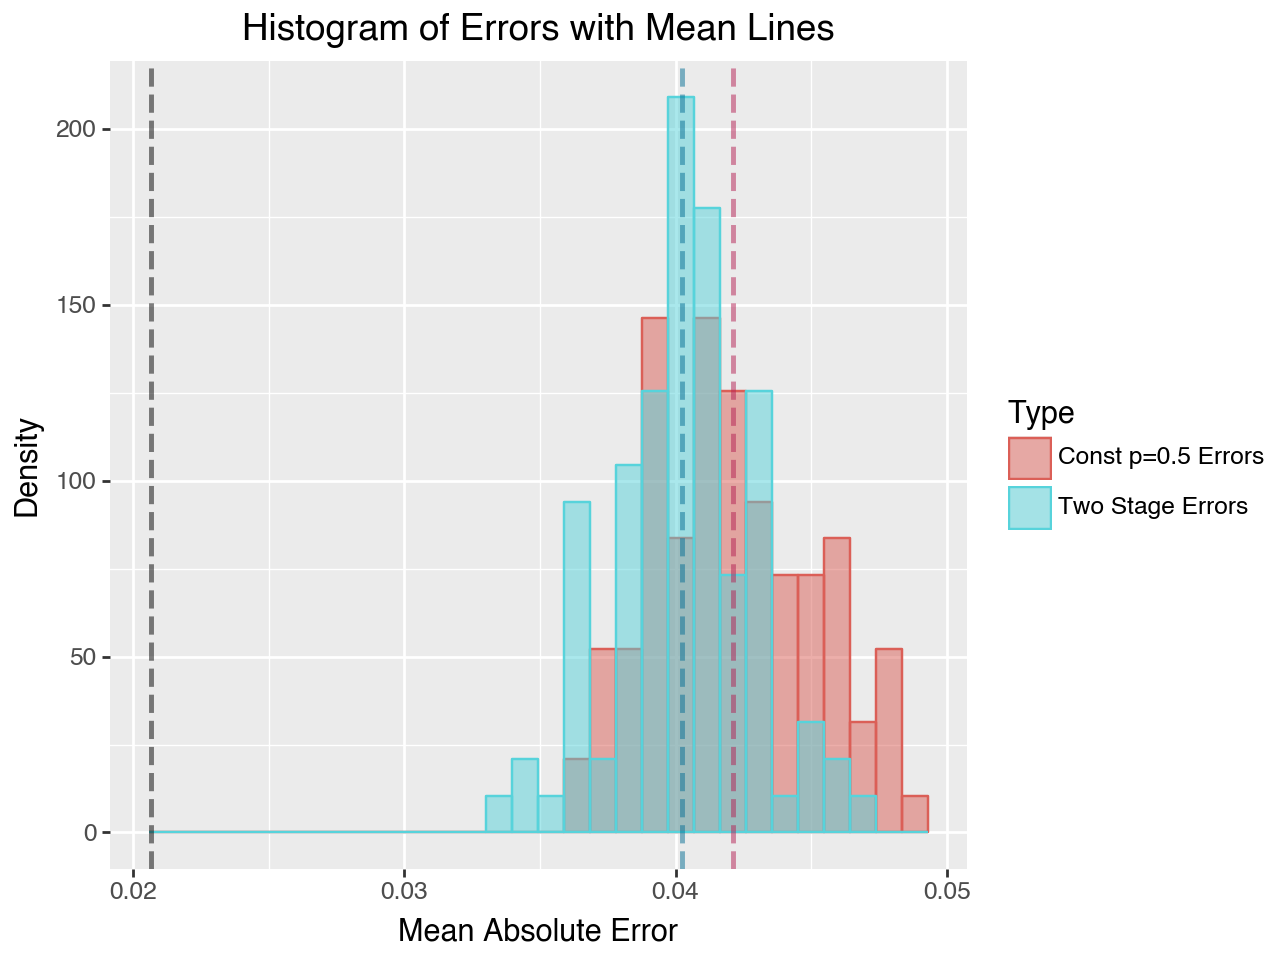

In [33]:
plot_two_stage_comparison(a, b, 0.02065173503858391)

I expect the improvement to be even larger when $\sigma_0 \neq \sigma_1$. If the potential outcome variances differ, then the oracle $p^*$ tells us to use
$$p^* = \frac{\sigma_1}{\sigma_0 + \sigma_1} + R \frac{\sigma_0}{\sigma_0 + \sigma_1}$$
where $R = \sigma_0 \sigma_1 / (n \sigma_b^2)$. In general, if $\sigma_0 \neq \sigma_1$, then the error from using $p=0.5$ has two sources:

1. using $R = 0$, and
2. using $\frac{\sigma_1}{\sigma_0 + \sigma_1} \approx 0.5$.

Error due to the first problem should decrease for large $\sigma_b$, since then $R$ approaches zero.

In [ ]:
flat_fitter = fitters.FitterFlatHyperpriors()
post_mean_estimator = estimators.PosteriorMeanEstimator(flat_fitter)

repetitions = 100
J_stage0 = 30
J_stage1 = 100
p0 = 0.5

const_p0_errors = []

for rep in tqdm(range(repetitions), desc="rep"):
    # generate data in first stage
    sim = utils.CHICK_SIMULATOR
    sim.n = np.array([utils.CHICK_N] * (J_stage0 + J_stage1))
    sim.p = np.array([p0] * (J_stage0 + J_stage1))

    data = sim.simulate()
    estimates = post_mean_estimator.result(data)
    const_p0_errors.append(estimates.sample_mae())

In [12]:
# for the remaining experiments, try the original p0 vs. the estimated p_star
# capping p_star at 0.95 to avoid very small groups

num_reps = 100
p0_errors = []
p_star_errors = []
for _ in tqdm(range(num_reps), desc="reps"):
    N_stage1 = 20
    N_stage2 = 50

    sim = utils.CHICK_SIMULATOR
    p0 = 0.5
    sim.n = np.array([utils.CHICK_N] * N_stage1)
    sim.p = np.array([p0] * N_stage1)

    data_stage1 = sim.simulate()
    sampler_stage1 = fitter_flat_hyperpriors.fit(data_stage1, show_progress=False)

    sigma_b_hat = np.mean(sampler_stage1.sigma_b)

    R = sim.sigma0 * sim.sigma1 / (sim.n[0] * sigma_b_hat**2)
    p_star = min(0.95, (sim.sigma0 + R * sim.sigma1) / (sim.sigma0 + sim.sigma1))

    sim_p0 = copy.deepcopy(sim)
    sim_p0.n = np.array([utils.CHICK_N] * N_stage2)
    sim_p0.p = np.array([p0] * N_stage2)

    sim_p_star = copy.deepcopy(sim)
    sim_p_star.n = np.array([utils.CHICK_N] * N_stage2)
    sim_p_star.p = np.array([p_star] * N_stage2)

    estimates_p0 = posterior_mean_estimator.result(
        sim_p0.simulate(), show_progress=False
    )
    estimates_p_star = posterior_mean_estimator.result(
        sim_p_star.simulate(), show_progress=False
    )

    p0_errors.append(estimates_p0.sample_mae())
    p_star_errors.append(estimates_p_star.sample_mae())

print(f"Average MAE for p = 0.5: {np.mean(np.array(p0_errors))}")
print(f"Average MAE for p = {p_star}: {np.mean(np.array(p_star_errors))}")

reps:   0%|          | 0/100 [00:00<?, ?it/s]

Average MAE for p = 0.5: 0.026969976660746173
Average MAE for p = 0.95: 0.02656135349066295


In [ ]:
# what if we use a prior based on the data generated in the first stage?
posterior_empirical_bayes = estimators.PosteriorMeanEstimator(
    fitters.FitterEstimatedHyperparameters()
)

num_reps = 30
errors = []
for _ in tqdm(range(num_reps), desc="reps"):
    N_stage1 = 20
    N_stage2 = 50

    sim = utils.CHICK_SIMULATOR
    p0 = 0.5
    sim.n = np.array([utils.CHICK_N] * N_stage1)
    sim.p = np.array([p0] * N_stage1)

    sim_p0 = copy.deepcopy(sim)
    sim_p0.n = np.array([utils.CHICK_N] * N_stage2)
    sim_p0.p = np.array([0.95] * N_stage2)

    estimates = posterior_empirical_bayes.result(sim_p0.simulate(), show_progress=False)
    errors.append(estimates.sample_mae())

print(f"Average MAE: {np.mean(np.array(errors))}")

reps:   0%|          | 0/30 [00:00<?, ?it/s]

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Average MAE: 0.027902406410379547


In [13]:
# for the remaining experiments, try the original p0 vs. the estimated p_star
# capping p_star at 0.95 to avoid very small groups

num_reps = 100
p0_errors = []
p_star_errors = []
for _ in tqdm(range(num_reps), desc="reps"):
    N_stage1 = 20
    N_stage2 = 50

    sim = utils.CHICK_SIMULATOR
    sim.sigma1 = 3 * sim.sigma0
    p0 = 0.5
    sim.n = np.array([utils.CHICK_N] * N_stage1)
    sim.p = np.array([p0] * N_stage1)

    data_stage1 = sim.simulate()
    sampler_stage1 = fitter_flat_hyperpriors.fit(data_stage1, show_progress=False)

    sigma_b_hat = np.mean(sampler_stage1.sigma_b)

    R = sim.sigma0 * sim.sigma1 / (sim.n[0] * sigma_b_hat**2)
    p_star = min(0.95, (sim.sigma0 + R * sim.sigma1) / (sim.sigma0 + sim.sigma1))

    sim_p0 = copy.deepcopy(sim)
    sim_p0.n = np.array([utils.CHICK_N] * N_stage2)
    sim_p0.p = np.array([p0] * N_stage2)

    sim_p_star = copy.deepcopy(sim)
    sim_p_star.n = np.array([utils.CHICK_N] * N_stage2)
    sim_p_star.p = np.array([p_star] * N_stage2)

    estimates_p0 = posterior_mean_estimator.result(
        sim_p0.simulate(), show_progress=False
    )
    estimates_p_star = posterior_mean_estimator.result(
        sim_p_star.simulate(), show_progress=False
    )

    p0_errors.append(estimates_p0.sample_mae())
    p_star_errors.append(estimates_p_star.sample_mae())

print(f"Average MAE for p = 0.5: {np.mean(np.array(p0_errors))}")
print(f"Average MAE for p = {p_star}: {np.mean(np.array(p_star_errors))}")

reps:   0%|          | 0/100 [00:00<?, ?it/s]

Average MAE for p = 0.5: 0.04452554876946844
Average MAE for p = 0.95: 0.04239304905444745


In [ ]:
# let's do this again but repeat a bunch of times and average

repetitions = 20
p0_rmses = []
p_star_rmses = []

N_stage1 = 10
N_stage2 = 50

for rep in tqdm(range(repetitions)):
    sim = utils.CHICK_SIMULATOR
    sim.sigma1 = 3 * sim.sigma0

    p_hat = 0.5
    sim.n = np.array([utils.CHICK_N] * N_stage1)
    sim.p = np.array([p_hat] * N_stage1)

    data_stage1 = sim.simulate()
    sampler_stage1 = fitter_flat_hyperpriors.fit(data_stage1, show_progress=False)

    sigma_b_hat_posterior_mean = np.mean(sampler_stage1.sigma_b)
    y1 = data_stage1.data["y1_bar"]
    y0 = data_stage1.data["y0_bar"]
    sigma_b_hat_mom = np.sqrt(np.cov(y1, y0, ddof=1)[0, 1])

    R = sim.sigma0 * sim.sigma1 / (sim.n[0] * sigma_b_hat_posterior_mean**2)
    p_star = min(0.95, (sim.sigma0 + R * sim.sigma1) / (sim.sigma0 + sim.sigma1))

    sim_p0 = copy.deepcopy(sim)
    sim_p0.n = np.array([utils.CHICK_N] * N_stage2)
    sim_p0.p = np.array([p_hat] * N_stage2)

    sim_p_star = copy.deepcopy(sim)
    sim_p_star.n = np.array([utils.CHICK_N] * N_stage2)
    sim_p_star.p = np.array([p_star] * N_stage2)

    estimates_p0 = posterior_mean_estimator.result(
        sim_p0.simulate(), show_progress=False
    )
    estimates_p_star = posterior_mean_estimator.result(
        sim_p_star.simulate(), show_progress=False
    )

    p0_rmses.append(estimates_p0.sample_mae())
    p_star_rmses.append(estimates_p_star.sample_mae())

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/fb/h3lz2z7j14j7hndqzb5_3cth0000gn/T/ipykernel_16149/2221400334.py:24: RuntimeWarning: invalid value encountered in sqrt
  sigma_b_hat_mom = np.sqrt(np.cov(y1, y0, ddof=1)[0, 1])


In [6]:
print(f"Mean absolute error for p0: {np.array(p0_rmses).mean()}")
print(f"Mean absolute error for p_star: {np.array(p_star_rmses).mean()}")

Mean absolute error for p0: 0.04597524664544421
Mean absolute error for p_star: 0.0446075996615634
